### Runmila AI Institute & minoHealth AI Labs Tuberculosis Classification via X-Rays Challenge

This competition is hosted on Zindi and can be accessed here https://zindi.africa/competitions/runmila-ai-institute-minohealth-ai-labs-tuberculosis-classification-via-x-rays-challenge. The objective of the challenge is to build a model that can classify Tuberculosis and Normal X-Ray results.

### 1. Importing libraries

In [25]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load data

In [3]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Runmila_AI_Institute_Challenge/Train.csv')
test_data = pd.read_csv('Runmila_AI_Institute_Challenge/Test.csv')
train_path = 'Runmila_AI_Institute_Challenge/train_small/'
test_path = 'Runmila_AI_Institute_Challenge/test_small/'

In [4]:
#creating train and test dataframe
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

In [5]:
train.head()

,filepath,LABEL,ID
0,Runmila_AI_Institute_Challenge/train_small/VTY...,Positive,VTYNBFTO
1,Runmila_AI_Institute_Challenge/train_small/GVV...,Normal,GVVXXDOZ
2,Runmila_AI_Institute_Challenge/train_small/PMR...,Normal,PMRSQLXN
3,Runmila_AI_Institute_Challenge/train_small/JXI...,Positive,JXISWDUU
4,Runmila_AI_Institute_Challenge/train_small/JVW...,Positive,JVWMAACC


In [6]:
test.head()

,filepath,ID
0,Runmila_AI_Institute_Challenge/test_small/GTWS...,GTWSHFYQ
1,Runmila_AI_Institute_Challenge/test_small/QTFS...,QTFSSMGD
2,Runmila_AI_Institute_Challenge/test_small/TBLB...,TBLBHSYT
3,Runmila_AI_Institute_Challenge/test_small/ZKET...,ZKETEOFG
4,Runmila_AI_Institute_Challenge/test_small/GKTP...,GKTPBGZP


In [7]:
train.shape, test.shape

((718, 3), (82, 2))

### 3. EDA and Preprocessing

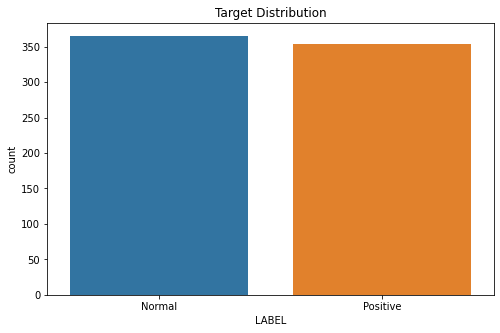

In [8]:
#visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

In [9]:
#we can see that our dataset is balanced with almost equal number of samples in each class
train.LABEL.value_counts()/len(train)

Normal      0.508357
Positive    0.491643
Name: LABEL, dtype: float64

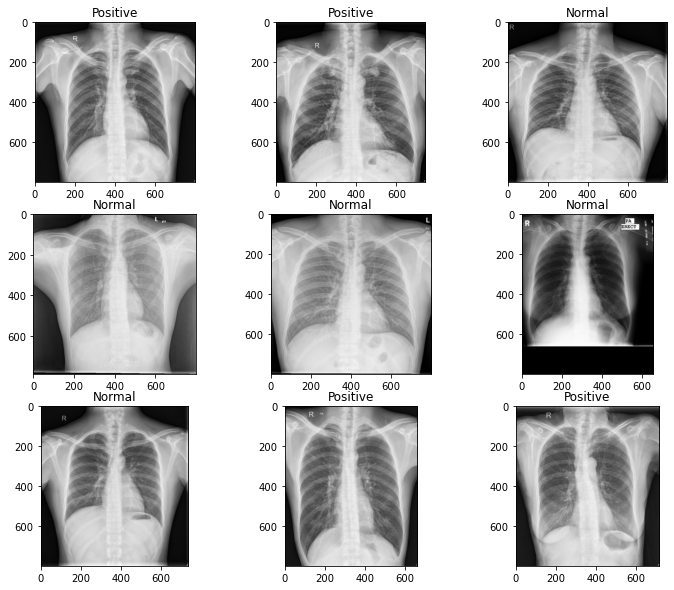

In [10]:
#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [11]:
#lets split our training data into train and validation set
#We have 718 training samples and i will use 80% train and 20% validation  
df_train = train[:575:]
df_val = train[575:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

Normal      295
Positive    280
Name: LABEL, dtype: int64
Positive    73
Normal      70
Name: LABEL, dtype: int64


In [12]:
#data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled

Found 575 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


### 4. Model building

In [13]:
#we will use transfer learning from VGG16 model

def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [14]:
model = BuildModel()

In [15]:
#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [16]:
#callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("Runmila_AI_Institute_Challenge/models/", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [17]:
#fit model
history = model.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.8873 - auc: 0.6665
Epoch 00001: val_loss improved from inf to 0.57700, saving model to Runmila_AI_Institute_Challenge/models\tb_model.h5
18/18 [==============================] - 102s 6s/step - loss: 0.8873 - auc: 0.6665 - val_loss: 0.5770 - val_auc: 0.7816
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 0.6863 - auc: 0.7946
Epoch 00002: val_loss improved from 0.57700 to 0.51420, saving model to Runmila_AI_Institute_Challenge/models\tb_model.h5
18/18 [==============================] - 109s 6s/step - loss: 0.6863 - auc: 0.7946 - val_loss: 0.5142 - val_auc: 0.8227
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.6210 - auc: 0.8087
Epoch 00003: val_loss did not improve from 0.51420
18/18 [==============================] - 106s 6s/step - loss: 0.6210 - auc: 0.8087 - val_loss: 0.6070 - val_auc: 0.7691
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 0.5952 - auc: 

In [18]:
#AUC
y_pred = model.predict(val_ds, verbose=1)[:, 1] 
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc = auc(fpr, tpr)
auc

5/5 [==============================] - 18s 4s/step


0.8632093933463795

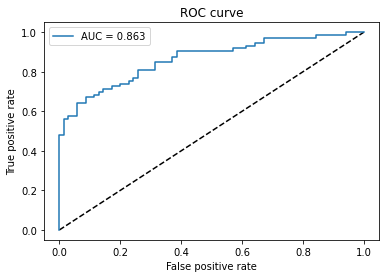

In [19]:
## plotting AUC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 5. Submission

In [20]:
#make predictions on test data
predictions = model.predict(test_ds)[:, 1]

In [21]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['LABEL'] = predictions

In [22]:
submission

,ID,LABEL
0,GTWSHFYQ,0.227805
1,QTFSSMGD,0.021622
2,TBLBHSYT,0.768562
3,ZKETEOFG,0.829189
4,GKTPBGZP,0.689552
...,...,...
77,UHRZNUCQ,0.375548
78,RQZCAYRX,0.283284
79,KGOETYSK,0.141275
80,ZPPGWFUO,0.863620


In [26]:
submission.to_csv('starter1.csv', index=False)